# Load an run a task graph

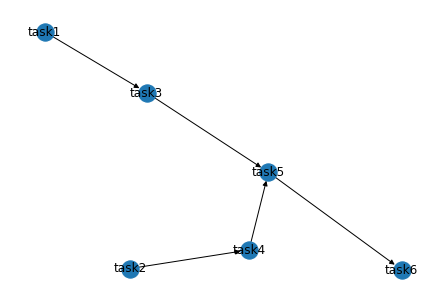

In [1]:
import networkx
import matplotlib.pyplot as plt
from esrftaskgraph import load_graph
from taskgraphlib import acyclic_graph1

varinfo = {"root_uri": "/tmp/myresults"}

persistent_taskgraph, expected_results = acyclic_graph1()

runtime_taskgraph = load_graph(persistent_taskgraph)

runtime_taskgraph.run(varinfo=varinfo)

networkx.draw(runtime_taskgraph.graph, with_labels=True)
plt.show()

# Instantiating a task

A task can always be instantiated and executed from the runtime representation of a task graph. No results from upstream tasks need to be provided explicitely. The runtime representation can be instantiated from the persistent representation with `load_graph`.

In [2]:
import inspect


def print_task_sourcecode(task):
    lines, line_nb = inspect.getsourcelines(type(task))
    print(" \nSource code:\n" + " ".join(lines))


def print_task_info(name, task):
    print(f"{name}: ")
    print(f" attributes = {runtime_taskgraph.graph.nodes[name]}")
    print(f" uhash = {task.uhash}")
    print(f" done = {task.done}")
    if task.done:
        print(f" result = {task.output.result.value}")
    else:
        print(" result = <not available>")


def instantiate_task(name):
    task = runtime_taskgraph.instantiate_task_static(name, varinfo=varinfo)
    print_task_info(name, task)
    return task


task = instantiate_task("task6")
print_task_sourcecode(task)

task6: 
 attributes = {'inputs': {'b': 6}, 'class': 'tasklib.tasks.SumTask'}
 uhash = c5ca4a1506781e600d048d14f0e889c0e596b1e2af2d7c7420da864fcbecbb6a
 done = True
 result = 16
 
Source code:
class SumTask(Task):
     INPUT_NAMES = ["a"]
     OPTIONAL_INPUT_NAMES = ["b"]
     OUTPUT_NAMES = ["result"]
 
     def process(self):
         result = self.input.a.value
         if self.input.b.value is not None:
             result += self.input.b.value
         self.output.result.value = result



# Modify and rerun task graphs

When modifying an input, re-running the task graph will only execute that tasks that are affected by this modification

In [3]:
modify_name = "task1"
dependent_name = "task6"
independent_name = "task4"

upstream = runtime_taskgraph.graph.nodes[modify_name]
upstream["inputs"]["a"] += 1

print("Modify inputs:")
task = instantiate_task(modify_name)

print("\nIndependent task:")
task = instantiate_task(independent_name)

print("\nDependent task:")
task = instantiate_task(dependent_name)

print("\nRun the new pipeline (graph instance) ...")
runtime_taskgraph.run(varinfo)

print("\nDependent task is a different instance:")
task = instantiate_task(dependent_name)

print("\nIndependent task is still the same instance:")
task = instantiate_task(independent_name)

Modify inputs:
task1: 
 attributes = {'inputs': {'a': 2}, 'class': 'tasklib.tasks.SumTask'}
 uhash = 24211b07c5c05d6071b13fc70cf72c44a81c31b4101eaac984e0467de60bfd26
 done = True
 result = 2

Independent task:
task4: 
 attributes = {'inputs': {'b': 4}, 'class': 'tasklib.tasks.SumTask'}
 uhash = 7f7d0a781e6653d431c4d9b2a1b14ab158a0cf8dce9adabd83d4c743034f964d
 done = True
 result = 6

Dependent task:
task6: 
 attributes = {'inputs': {'b': 6}, 'class': 'tasklib.tasks.SumTask'}
 uhash = edf06fd90e0e243cbda5dacb3ec048f831b319263a86be620f2269aa9f8435f8
 done = True
 result = 17

Run the new pipeline (graph instance) ...

Dependent task is a different instance:
task6: 
 attributes = {'inputs': {'b': 6}, 'class': 'tasklib.tasks.SumTask'}
 uhash = edf06fd90e0e243cbda5dacb3ec048f831b319263a86be620f2269aa9f8435f8
 done = True
 result = 17

Independent task is still the same instance:
task4: 
 attributes = {'inputs': {'b': 4}, 'class': 'tasklib.tasks.SumTask'}
 uhash = 7f7d0a781e6653d431c4d9b2a1b

# Task graph as a hash tree

Create a dictionary of all runtime representations of tasks

In [4]:
tasks = dict()
for name in runtime_taskgraph.graph.nodes:
    runtime_taskgraph.instantiate_task_static(name, tasks=tasks, varinfo=varinfo)

The same python object of a task represents a different task instance when modifying upstream input as a result of hash linking

In [5]:
modify_name = "task1"
dependent_name = "task6"

task = tasks[dependent_name]

print("Task represented by the python object:")
print_task_info(dependent_name, task)

print("\nModify upstream input:")
tasks[modify_name].input.a.value += 1
print_task_info(dependent_name, task)

print("\nReset upstream input:")
tasks[modify_name].input.a.value -= 1
print_task_info(dependent_name, task)

Task represented by the python object:
task6: 
 attributes = {'inputs': {'b': 6}, 'class': 'tasklib.tasks.SumTask'}
 uhash = edf06fd90e0e243cbda5dacb3ec048f831b319263a86be620f2269aa9f8435f8
 done = True
 result = 17

Modify upstream input:
task6: 
 attributes = {'inputs': {'b': 6}, 'class': 'tasklib.tasks.SumTask'}
 uhash = c4dfd2fd67939f6c316ed4963a035f72f656541d2f0705ed61c13d4563a81b90
 done = False
 result = <not available>

Reset upstream input:
task6: 
 attributes = {'inputs': {'b': 6}, 'class': 'tasklib.tasks.SumTask'}
 uhash = edf06fd90e0e243cbda5dacb3ec048f831b319263a86be620f2269aa9f8435f8
 done = True
 result = 17
